In [2]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import pandas as pd
import random
from scipy.stats import pearsonr
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load GraphML data
graphml_file_path = '/content/drive/MyDrive/ed_proj/network.graphml'

# Create a directed graph
G = nx.DiGraph()

tree = ET.parse(graphml_file_path)
root = tree.getroot()
graphml_ns = {'g': 'http://graphml.graphdrawing.org/xmlns'}

# # Extract nodes with attributes
# for node in root.findall(".//g:node", namespaces=graphml_ns):
#     node_id = node.get('id')
#     name = node.find("g:data[@key='v_name']", namespaces=graphml_ns).text
#     cluster = int(node.find("g:data[@key='v_cluster']", namespaces=graphml_ns).text)
#     G.add_node(node_id, name=name, cluster=cluster)

# # Extract edges with weights
# for edge in root.findall(".//g:edge", namespaces=graphml_ns):
#     source = edge.get('source')
#     target = edge.get('target')
#     weight = float(edge.find("g:data[@key='e_weight']", namespaces=graphml_ns).text)
#     G.add_edge(source, target, weight=weight)

# Specify the path to your dataset
file_path = '/content/drive/MyDrive/ed_proj/user_features.csv'

# Load the dataset
user_features = pd.read_csv(file_path)

print(G)
print(G.edges)

print(user_features.columns)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DiGraph with 0 nodes and 0 edges
[]
Index(['index', 'uid', 'cluster', 'friend_count', 'status_count',
       'follower_count', 'friends_day', 'statuses_day', 'followers_day',
       'retweet_pro', 'dmention_pro', 'reply_pro', 'retweet_div', 'reply_div',
       'mention_div', 'i', 'we', 'negate', 'swear', 'social', 'posemo',
       'negemo', 'body', 'health', 'ingest', 'prostr'],
      dtype='object')


In [17]:
import re

# Extract nodes with attributes
for node in root.findall(".//g:node", namespaces=graphml_ns):
    node_id = node.get('id')

    # Extract numerical part from 'v_id'
    uid_match = re.search(r'\d+', node.find("g:data[@key='v_id']", namespaces=graphml_ns).text)

    if uid_match:
        uid = int(uid_match.group())

        # Assuming 'uid' is a column in user_features that corresponds to user IDs in the graph
        user_data = user_features[user_features['uid'] == uid]

        # Check if user data is available for the node
        if not user_data.empty:
            # Example: Assign edge weight based on the 'statuses_day' feature
            weight_value = float(user_data['status_count'].values[0])

            # Add node and assign the computed weight to the edge
            G.add_node(node_id, uid=uid, name=node.find("g:data[@key='v_name']", namespaces=graphml_ns).text, cluster=node.find("g:data[@key='v_cluster']", namespaces=graphml_ns).text)
            G.nodes[node_id]['weight'] = weight_value
        else:
            # If user data is missing for any node, you can decide how to handle it.
            # Here, we set a default weight of 0.5, but you can customize this based on your needs.
            G.add_node(node_id, uid=uid, name=node.find("g:data[@key='v_name']", namespaces=graphml_ns).text, cluster=node.find("g:data[@key='v_cluster']", namespaces=graphml_ns).text)
            G.nodes[node_id]['weight'] = 0.5

# Extract edges with weights
for edge in root.findall(".//g:edge", namespaces=graphml_ns):
    source = edge.get('source')
    target = edge.get('target')

    # Calculate the edge weight as the product of 'statuses_day' values of the source and target nodes
    source_uid = int(re.search(r'\d+', source).group())
    target_uid = int(re.search(r'\d+', target).group())
    source_weight = G.nodes[f'n{source_uid}']['weight']
    target_weight = G.nodes[f'n{target_uid}']['weight']
    weight = (source_weight * target_weight)/2

    G.add_edge(source, target, weight=weight)

# Now G is a graph with nodes having attributes uid, name, cluster, and weight
print(G)


# # Print edges with weights
# for edge in G.edges(data=True):
#     source, target, data = edge
#     weight = data.get('weight', None)  # Get the 'weight' attribute, default to None if not present
#     print(f"Edge: {source} -> {target}, Weight: {weight}")

#Calculate the average weight
# Initialize variables to store total weight and edge count
total_weight = 0
edge_count = 0
min_weight = float('inf')  # Set to positive infinity initially
max_weight = float('-inf')  # Set to negative infinity initially

for edge in G.edges(data=True):
    source, target, data = edge
    weight = data.get('weight', None)

    if weight is not None:
        total_weight += weight
        edge_count += 1
        min_weight = min(min_weight, weight)
        max_weight = max(max_weight, weight)

# Calculate average weight
average_weight = total_weight / edge_count if edge_count > 0 else 0

# Print the average weight
print(f"Average Weight: {average_weight}")

#Print min and max weights
print(f"Minimum Weight: {min_weight}")
print(f"Maximum Weight: {max_weight}")



DiGraph with 6169 nodes and 11056 edges
Average Weight: 4080240.0550719067
Minimum Weight: 0.125
Maximum Weight: 622988970.0


In [9]:
def strength_of_ties_diffusion(graph, threshold, initial_active_nodes, max_steps):
    """
    Simulate diffusion in a graph.

    Args:
        graph (networkx.Graph): The input graph.
        threshold (float): The weight threshold for activation.
        initial_active_nodes (list): List of initially active nodes.
        max_steps (int): Maximum number of diffusion steps.

    Returns:
        active_nodes (set): Nodes that are active after diffusion.
    """
    active_nodes = set(initial_active_nodes)

    for _ in range(max_steps):
        newly_activated_nodes = set()

        for edge in graph.edges(data=True):
            source, target, data = edge
            weight = data.get('weight', 0)

            # Check if weight surpasses the threshold
            if weight > threshold:
                # Check if either node is active
                if source in active_nodes or target in active_nodes:
                    newly_activated_nodes.add(source)
                    newly_activated_nodes.add(target)

        # Update the set of active nodes
        active_nodes.update(newly_activated_nodes)

        # Stop diffusion if no new nodes are activated
        if not newly_activated_nodes:
            break

    return active_nodes


In [20]:
import time
from scipy import stats

#Calculate the ratio of nodes from the pre-defined clusters
def calc_ratio_nodes_from_clusters(nodes,type):
  total_nodes = len(nodes)
  cluster_0_count = 0
  cluster_1_count = 0

  for node in nodes:
    uid = G.nodes[node]['uid']  # Assuming 'uid' is the column in user_features corresponding to user IDs in the graph

    # Check if there is a row in user_features with the specified 'uid'
    user_row = user_features[user_features['uid'] == uid]

    if not user_row.empty:
        cluster_value = user_row['cluster'].values[0]

        if cluster_value == 0:
            cluster_0_count += 1
        elif cluster_value == 1:
            cluster_1_count += 1
    else:
        # Handle the case where no row is found for the given 'uid'
        continue

  # Calculate the ratio
  cluster_0_ratio = (cluster_0_count / total_nodes)*100
  cluster_1_ratio = (cluster_1_count / total_nodes)*100

  print(f"Percent of {type} in Cluster 0: {cluster_0_ratio:.2f}%")
  print(f"Percent of {type} in Cluster 1: {cluster_1_ratio:.2f}%")


  return [cluster_0_ratio, cluster_1_ratio]

# Degree based seed selection
def degree_based_seed_selection(graph, num_seeds):
    sorted_nodes = sorted(graph.nodes(), key=lambda x: graph.degree(x), reverse=True)
    return sorted_nodes[:num_seeds]

seed_nodes = degree_based_seed_selection(G, 300)
burned_nodes = strength_of_ties_diffusion(G, 400, seed_nodes, 5)

#Print activated nodes
print(burned_nodes)


#Finding the ratio of nodes in 2 clusters{'0','1'}
calc_ratio_nodes_from_clusters(seed_nodes, "Seed Nodes")
calc_ratio_nodes_from_clusters(burned_nodes, "Activated Nodes")

# Ensure at least some seeds
if len(seed_nodes) == 0:
  seed_edges = None

if len(burned_nodes) > 0:
  diffusion_reach = len(burned_nodes) / G.order()
  print(f'Diffusion Spread={diffusion_reach*100}%')
else:
  print("No diffusion spread!")
  diffusion_reach = 0

#Calculate the speed of diffusion - TIME
def calculate_time_to_influence(model_name, diffusion_function, seeds):
    start_time = time.time()
    active_nodes = strength_of_ties_diffusion(G, 400, seed_nodes, 5)
    elapsed_time = time.time() - start_time
    print(f"{model_name}-Time(Speed) to Influence: {elapsed_time:.4f} seconds")
    return elapsed_time

diffusion_speed = calculate_time_to_influence("Strength of Ties diffusion", strength_of_ties_diffusion, burned_nodes)



{'n1719', 'n5237', 'n450', 'n4422', 'n2027', 'n1519', 'n1133', 'n3796', 'n507', 'n2290', 'n2909', 'n2838', 'n0', 'n5108', 'n2651', 'n46', 'n5203', 'n4486', 'n4581', 'n2475', 'n2586', 'n447', 'n4354', 'n2761', 'n1597', 'n4659', 'n5851', 'n3160', 'n4235', 'n736', 'n2510', 'n106', 'n4814', 'n2922', 'n3412', 'n2616', 'n2921', 'n1556', 'n1251', 'n5087', 'n2108', 'n2553', 'n2754', 'n412', 'n394', 'n2587', 'n2021', 'n525', 'n3685', 'n2066', 'n1901', 'n2224', 'n1929', 'n3433', 'n1367', 'n2568', 'n2638', 'n1772', 'n3411', 'n4187', 'n2063', 'n5911', 'n1508', 'n3533', 'n3000', 'n2602', 'n1220', 'n4124', 'n1981', 'n1747', 'n3916', 'n1431', 'n2118', 'n4506', 'n355', 'n1052', 'n1202', 'n689', 'n1467', 'n3747', 'n1729', 'n2405', 'n3144', 'n4677', 'n4826', 'n260', 'n1068', 'n633', 'n2478', 'n2834', 'n672', 'n5426', 'n1994', 'n3807', 'n1080', 'n1940', 'n2763', 'n3234', 'n3084', 'n4498', 'n3879', 'n1888', 'n2148', 'n798', 'n1744', 'n678', 'n2653', 'n4706', 'n2719', 'n117', 'n3806', 'n4778', 'n660', 'n14

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 65.71%
Percent of Activated Nodes in Cluster 1: 5.53%


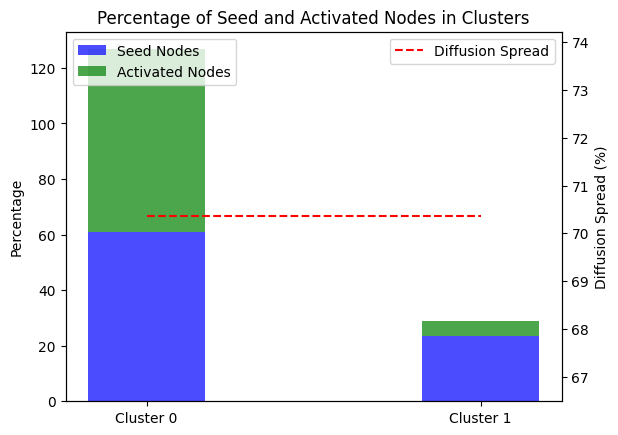

In [21]:
import matplotlib.pyplot as plt

# Percentages
seed_nodes_percentages = calc_ratio_nodes_from_clusters(seed_nodes, "Seed Nodes")
activated_nodes_percentages = calc_ratio_nodes_from_clusters(burned_nodes, "Activated Nodes")

diffusion_spread = diffusion_reach*100

# Plotting the percentages
labels = ['Cluster 0', 'Cluster 1']
bar_width = 0.35

fig, ax1 = plt.subplots()

# Bar chart for percentages
ax1.bar(labels, seed_nodes_percentages, width=bar_width, label='Seed Nodes', color='b', alpha=0.7)
ax1.bar(labels, activated_nodes_percentages, width=bar_width, label='Activated Nodes', color='g', alpha=0.7, bottom=seed_nodes_percentages)

# Adding labels and title
ax1.set_ylabel('Percentage')
ax1.set_title('Percentage of Seed and Activated Nodes in Clusters')

# Creating a second y-axis for the diffusion spread
ax2 = ax1.twinx()
ax2.plot(labels, [diffusion_spread, diffusion_spread], 'r--', label='Diffusion Spread')
ax2.set_ylabel('Diffusion Spread (%)')

# Show the legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()




1. Friend count:
burned_nodes = strength_of_ties_diffusion(G, 500, seed_nodes, 5)
Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 85.85%
Percent of Activated Nodes in Cluster 1: 7.20%
Diffusion Spread=53.37980223699142%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0650 seconds

2. Status count:
burned_nodes = strength_of_ties_diffusion(G, 500, seed_nodes, 5)
Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 67.58%
Percent of Activated Nodes in Cluster 1: 5.69%
Diffusion Spread=68.357918625385%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0684 seconds

3. Follower count: threshold: 1000
burned_nodes = strength_of_ties_diffusion(G, 1000, seed_nodes, 10)
Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 55.40%
Percent of Activated Nodes in Cluster 1: 4.62%
Diffusion Spread=57.39990273950397%
Strength of Ties diffusion-Time(Speed) to Influence: 0.1030 seconds

4. Friends per day
burned_nodes = strength_of_ties_diffusion(G, 0.2, seed_nodes, 5)
Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 58.51%
Percent of Activated Nodes in Cluster 1: 5.58%
Diffusion Spread=48.84097908899335%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0748 seconds

5. Statuses day: thershold: 7
burned_nodes = strength_of_ties_diffusion(G, 7, seed_nodes, 10)
Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 83.97%
Percent of Activated Nodes in Cluster 1: 8.40%
Diffusion Spread=24.882476900632195%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0826 seconds

6. followers_day:
burned_nodes = strength_of_ties_diffusion(G, 0.5, seed_nodes, 10)
DiGraph with 6169 nodes and 11056 edges
Average Weight: 5.845549267957766
Minimum Weight: 0.0006852058451426718
Maximum Weight: 8927.818831045293

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 58.74%
Percent of Activated Nodes in Cluster 1: 6.44%
Diffusion Spread=42.551467012481766%
Strength of Ties diffusion-Time(Speed) to Influence: 0.1296 seconds


7. retweet_pro:
burned_nodes = strength_of_ties_diffusion(G, 0.05, seed_nodes, 10)
DiGraph with 6169 nodes and 11056 edges
Average Weight: 0.060095636401385294
Minimum Weight: 0.0
Maximum Weight: 0.3729513016424445

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 34.61%
Percent of Activated Nodes in Cluster 1: 3.03%
Diffusion Spread=58.404927865132116%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0750 seconds

8. dmention_pro:
burned_nodes = strength_of_ties_diffusion(G, 0.05, seed_nodes, 5)
DiGraph with 6169 nodes and 11056 edges
Average Weight: 0.07178333941394237
Minimum Weight: 0.0
Maximum Weight: 0.350951027084452

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 36.13%
Percent of Activated Nodes in Cluster 1: 4.10%
Diffusion Spread=68.47138920408494%
Strength of Ties diffusion-Time(Speed) to Influence: 0.1132 seconds


9. reply_pro:
burned_nodes = strength_of_ties_diffusion(G, 0.009, seed_nodes, 5)
DiGraph with 6169 nodes and 11056 edges
Average Weight: 0.03176288119984231
Minimum Weight: 0.0
Maximum Weight: 0.15915915915

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 26.15%
Percent of Activated Nodes in Cluster 1: 3.71%
Diffusion Spread=62.42502836764467%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0637 seconds


10. retweet_div:
burned_nodes = strength_of_ties_diffusion(G, 2, seed_nodes, 5)
DiGraph with 6169 nodes and 11056 edges
Average Weight: 4.961873005512808
Minimum Weight: 0.0
Maximum Weight: 27.12527153388014

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 90.94%
Percent of Activated Nodes in Cluster 1: 7.52%
Diffusion Spread=49.76495380126439%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0628 seconds

11. reply_div:
burned_nodes = strength_of_ties_diffusion(G, 1, seed_nodes, 5)
DiGraph with 6169 nodes and 11056 edges
Average Weight: 2.439587139706715
Minimum Weight: 0.0
Maximum Weight: 20.251637655632372

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 73.45%
Percent of Activated Nodes in Cluster 1: 6.48%
Diffusion Spread=57.07570108607554%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0654 seconds


12. mention_div:
burned_nodes = strength_of_ties_diffusion(G, 1, seed_nodes, 5)
Average Weight: 2.047208874255437
Minimum Weight: 0.0
Maximum Weight: 18.804255640671293

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 81.84%
Percent of Activated Nodes in Cluster 1: 7.43%
Diffusion Spread=49.71632355325012%
Strength of Ties diffusion-Time(Speed) to Influence: 0.1371 seconds

13. i:
burned_nodes = strength_of_ties_diffusion(G, 0.009, seed_nodes, 5)
DiGraph with 6169 nodes and 11056 edges
Average Weight: 0.028247156627833673
Minimum Weight: 0.0
Maximum Weight: 0.125

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 17.73%
Percent of Activated Nodes in Cluster 1: 2.44%
Diffusion Spread=54.384827362619546%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0590 seconds


14. we :
active_nodes = strength_of_ties_diffusion(G, 0.0009, seed_nodes, 5)
DiGraph with 6169 nodes and 11056 edges
Average Weight: 0.01918195654185508
Minimum Weight: 0.0
Maximum Weight: 0.125

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 11.50%
Percent of Activated Nodes in Cluster 1: 3.62%
Diffusion Spread=38.045064029826555%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0863 seconds

15. negate :
active_nodes = strength_of_ties_diffusion(G, 0.009, seed_nodes, 5)
DiGraph with 6169 nodes and 11056 edges
Average Weight: 0.020973429913452194
Minimum Weight: 0.0
Maximum Weight: 0.125

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 12.92%
Percent of Activated Nodes in Cluster 1: 4.27%
Diffusion Spread=26.600745663802883%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0577 seconds

16. swear :
burned_nodes = strength_of_ties_diffusion(G, 0.001, seed_nodes, 5)
Average Weight: 0.01938666262834572
Minimum Weight: 0.0
Maximum Weight: 0.125

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 15.58%
Percent of Activated Nodes in Cluster 1: 2.50%
Diffusion Spread=48.06289512076511%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0632 seconds

17. social
burned_nodes = strength_of_ties_diffusion(G, 0.009, seed_nodes, 5)
Average Weight: 0.02807412126815439
Minimum Weight: 0.0
Maximum Weight: 0.125

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 15.74%
Percent of Activated Nodes in Cluster 1: 2.86%
Diffusion Spread=57.86999513697519%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0641 seconds

18. posemo
burned_nodes = strength_of_ties_diffusion(G, 0.009, seed_nodes, 5)

Average Weight: 0.023573955930623634
Minimum Weight: 0.0
Maximum Weight: 0.125

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 13.83%
Percent of Activated Nodes in Cluster 1: 2.80%
Diffusion Spread=53.33117198897715%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0627 seconds

19. negemo
burned_nodes = strength_of_ties_diffusion(G, 0.009, seed_nodes, 5)

Average Weight: 0.021975681961150174
Minimum Weight: 0.0
Maximum Weight: 0.125

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 15.02%
Percent of Activated Nodes in Cluster 1: 2.81%
Diffusion Spread=42.63251742583887%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0920 seconds

20. body
burned_nodes = strength_of_ties_diffusion(G, 0.009, seed_nodes, 5)

Average Weight: 0.02012228741556892
Minimum Weight: 0.0
Maximum Weight: 0.12

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 13.47%
Percent of Activated Nodes in Cluster 1: 5.04%
Diffusion Spread=22.499594747933212%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0560 seconds

21. health
burned_nodes = strength_of_ties_diffusion(G, 0.009, seed_nodes, 5)

Average Weight: 0.020104557211330754
Minimum Weight: 0.0
Maximum Weight: 0.125

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 13.49%
Percent of Activated Nodes in Cluster 1: 5.15%
Diffusion Spread=22.35370400389042%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0515 seconds

22. ingest
burned_nodes = strength_of_ties_diffusion(G, 0.009, seed_nodes, 5)

Average Weight: 0.02109808817139669
Minimum Weight: 0.0
Maximum Weight: 0.125

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 12.71%
Percent of Activated Nodes in Cluster 1: 3.52%
Diffusion Spread=33.14961906305722%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0907 seconds

23. prostr
burned_nodes = strength_of_ties_diffusion(G, 0.009, seed_nodes, 5)

Average Weight: 0.01971507786108884
Minimum Weight: -0.022727272725
Maximum Weight: 0.125

Percent of Seed Nodes in Cluster 0: 61.00%
Percent of Seed Nodes in Cluster 1: 23.33%
Percent of Activated Nodes in Cluster 0: 12.68%
Percent of Activated Nodes in Cluster 1: 4.41%
Diffusion Spread=26.08202301831739%
Strength of Ties diffusion-Time(Speed) to Influence: 0.0674 seconds





